In [1]:
import datetime
import pandas as pd
from theoEngine import TheoEngine

from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

In [2]:
underlying_pair = "BTC/USD"
underlying_price = 3607
atm_volatility = .6   # decimal, annualized
interest_rate = 0

theo_engine = TheoEngine(
    underlying_pair=underlying_pair,
    underlying_price=underlying_price,
    atm_volatility=atm_volatility,
    interest_rate=interest_rate
)
theo_engine.build_deribit_options()

In [5]:
digit = .00000000000000124235235

In [10]:
digit_str = str(digit)
print(digit_str)

1.24235235e-15


In [11]:
if digit_str.replace('.','',1).isdigit() or 'e-' in digit_str:
    print(round(float(digit_str), 3))

0.0


In [3]:
theo_engine.calc_deribit_implied_vols()

No market for BTC/USD 20000.0 call with expiry 2019-06-28 08:00:00+00:00
Calculated IV for BTC/USD 12000.0 call with expiry 2019-06-28 08:00:00+00:00: 0.7342529296875
Calculated IV for BTC/USD 4000.0 call with expiry 2019-06-28 08:00:00+00:00: 0.5752441406250001
No market for BTC/USD 14000.0 call with expiry 2019-06-28 08:00:00+00:00
No market for BTC/USD 13000.0 call with expiry 2019-06-28 08:00:00+00:00
Calculated IV for BTC/USD 3500.0 call with expiry 2019-06-28 08:00:00+00:00: 0.583154296875
Calculated IV for BTC/USD 8000.0 call with expiry 2019-06-28 08:00:00+00:00: 0.618359375
No market for BTC/USD 15000.0 call with expiry 2019-06-28 08:00:00+00:00
Calculated IV for BTC/USD 9000.0 call with expiry 2019-06-28 08:00:00+00:00: 0.643603515625
Calculated IV for BTC/USD 7000.0 call with expiry 2019-06-28 08:00:00+00:00: 0.600860595703125
Calculated IV for BTC/USD 5000.0 call with expiry 2019-06-28 08:00:00+00:00: 0.56953125
Calculated IV for BTC/USD 2000.0 call with expiry 2019-06-28 0

Calculated IV for BTC/USD 6000.0 put with expiry 2019-09-27 08:00:00+00:00: 0.6462570190429686
Calculated IV for BTC/USD 11000.0 put with expiry 2019-09-27 08:00:00+00:00: 0.7678161621093749
Calculated IV for BTC/USD 4500.0 put with expiry 2019-09-27 08:00:00+00:00: 0.6195785522460937
Calculated IV for BTC/USD 5500.0 put with expiry 2019-09-27 08:00:00+00:00: 0.6291168212890625
Calculated IV for BTC/USD 2500.0 put with expiry 2019-09-27 08:00:00+00:00: 0.6730072021484375
Calculated IV for BTC/USD 9000.0 put with expiry 2019-09-27 08:00:00+00:00: 0.702410888671875
Calculated IV for BTC/USD 2000.0 put with expiry 2019-09-27 08:00:00+00:00: 0.7143157958984374
Calculated IV for BTC/USD 12000.0 put with expiry 2019-09-27 08:00:00+00:00: 0.8010925292968751
Calculated IV for BTC/USD 3000.0 put with expiry 2019-09-27 08:00:00+00:00: 0.6480499267578125
Calculated IV for BTC/USD 10000.0 put with expiry 2019-03-29 08:00:00+00:00: 4.733165431326071e-31
No market for BTC/USD 25000.0 put with expiry

In [40]:
def plot_vol_surface(theo_engine, option_type):
    min_vol = .1
    max_vol = 2
    min_delta = .1
    max_delta = .9
    min_days_until_expiration = 10
    vols = []
    deltas = []
    times = []
    for option in theo_engine.iterate_options():
        if option.option_type == option_type \
            and option.mid_market is not None \
            and option.vol > min_vol \
            and option.vol < max_vol:
            if option.mid_market is not None and option.vol > min_vol and option.vol < max_vol:
                option.calc_greeks()
                if abs(option.delta) > min_delta \
                    and abs(option.delta) < max_delta \
                    and option.time_left * 365 > min_days_until_expiration:
                    vols.append(option.vol)
                    deltas.append(option.delta)
                    times.append(option.time_left * 365)
    
    data = []
    assert len(deltas) == len(vols) and len(deltas) == len(times) 
    for i in range(len(deltas)):
        data.append((deltas[i], times[i], vols[i]))
    x, y, z = zip(*data)
    z = list(map(float, z))
    grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]
    grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

    fig = plt.figure()
    ax = fig.gca(projection='3d', 
                 title='Volatility surface for ' + underlying_pair + " " + option_type + "s",
                 xlabel="Delta",
                 ylabel="Days until expiration",
                 zlabel="Volatility")
    ax.plot_surface(grid_x, grid_y, grid_z, cmap=plt.cm.Spectral)
    plt.show()

<IPython.core.display.Javascript object>


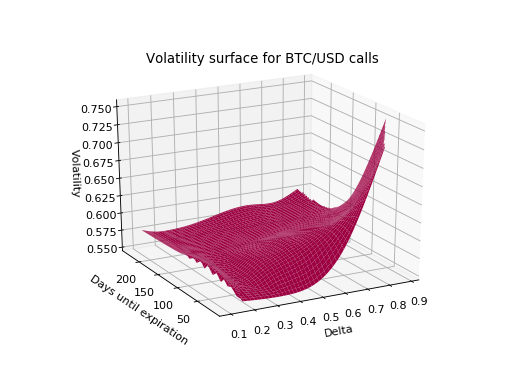

<IPython.core.display.Javascript object>


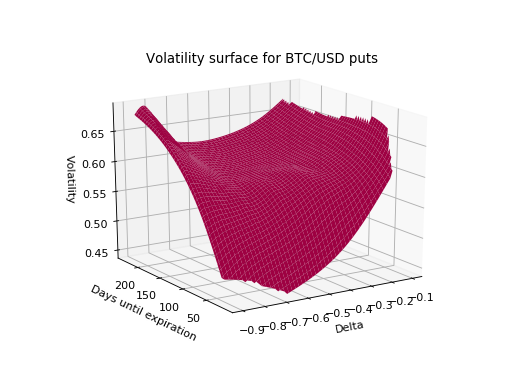

In [41]:
plot_vol_surface(theo_engine, 'call')
plot_vol_surface(theo_engine, 'put')

In [44]:
option_df_dict = {
    'call': {},
    'put': {}
}
for expiry in theo_engine.expirations:
    for call_put in ['call','put']:
        option_df_dict[call_put][expiry] = {}
    for strike in theo_engine.strikes[expiry]:
        for call_put in ['call','put']:
            option_df_dict[call_put][expiry][strike] = pd.DataFrame(columns=['Theo','Delta','Gamma','Theta'])

lower_underlying_price = 2000
upper_underlying_price = 6000
increment=25
for price in range(lower_underlying_price, upper_underlying_price, increment):
    print("Calculating greeks for underlying price=" + str(price) + "...")
    theo_engine.update_underlying_price(price)
    for expiry in theo_engine.expirations:
        for strike in theo_engine.strikes[expiry]:
            for call_put in ['call','put']:
                option = theo_engine.options[call_put][expiry][strike]
                option_df_dict[call_put][expiry][strike].loc[price] = [option.theo, option.delta, option.gamma, option.theta]

In [9]:
def plot_by_strike(option_df_dict, expiry, variable):
    for call_put in ['call','put']:
        strike = list(option_df_dict[call_put][expiry])[0]
        title= str(expiry) + " " + call_put + "s"
        is_first = True
        for strike in list(option_df_dict[call_put][expiry]):
            df = option_df_dict[call_put][expiry][strike].copy()
            df.columns = [x + "_" + str(strike) for x in df.columns]
            if is_first:
                ax = df.plot(y=[variable + "_" + str(strike)], title=title)
                ax.set_xlabel = "Underlying price (" + underlying_pair.split('/')[1] + ")"
                ax.set_ylabel = variable
                is_first = False
            else:
                df.plot(y=[variable + "_" + str(strike)], ax=ax)

<IPython.core.display.Javascript object>


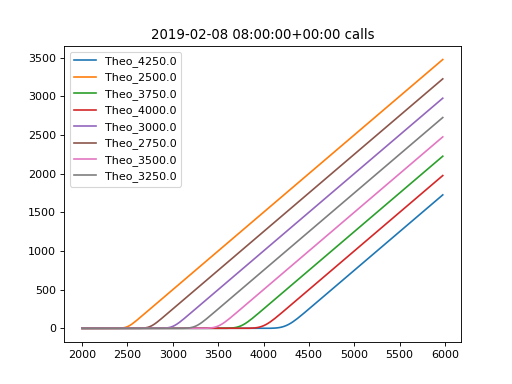

<IPython.core.display.Javascript object>


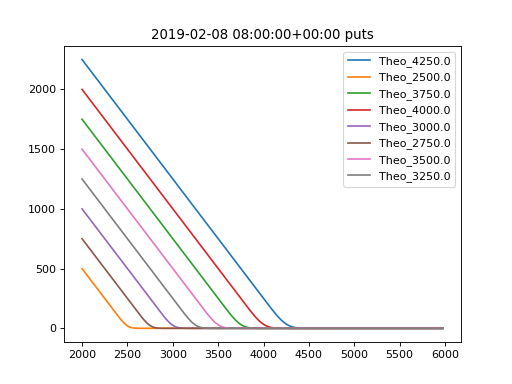

<IPython.core.display.Javascript object>


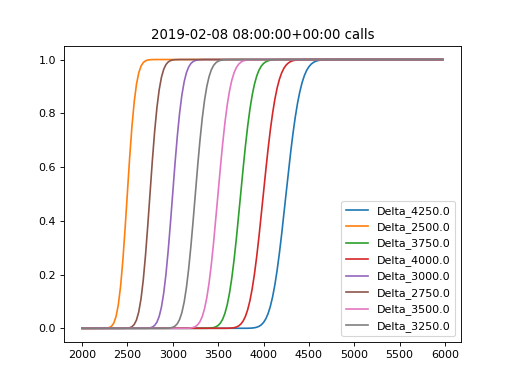

<IPython.core.display.Javascript object>


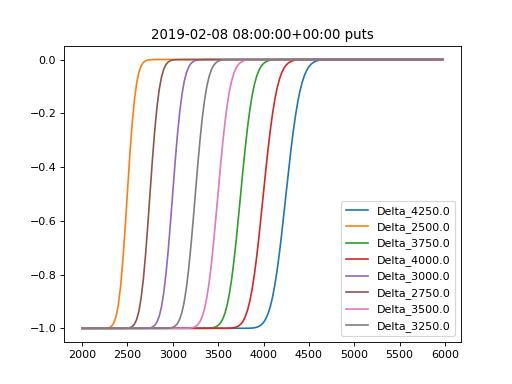

<IPython.core.display.Javascript object>


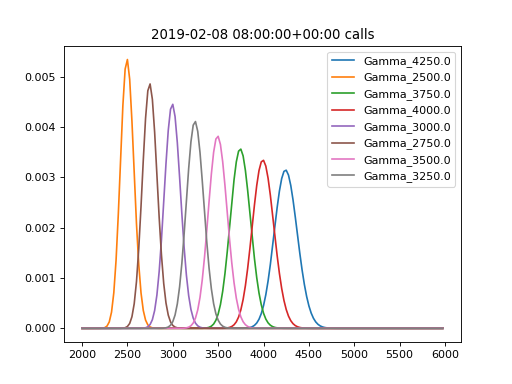

<IPython.core.display.Javascript object>


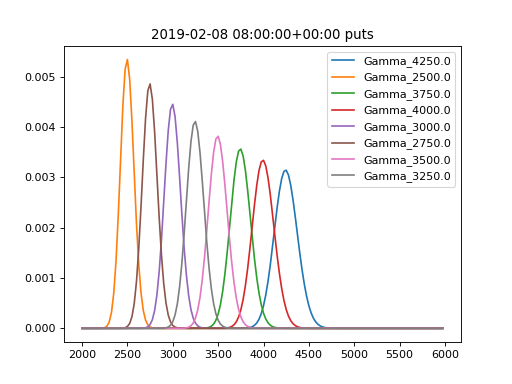

<IPython.core.display.Javascript object>


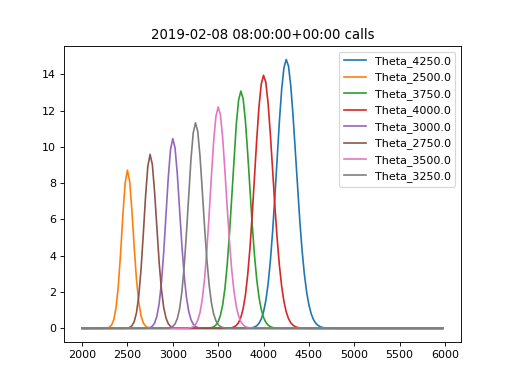

<IPython.core.display.Javascript object>


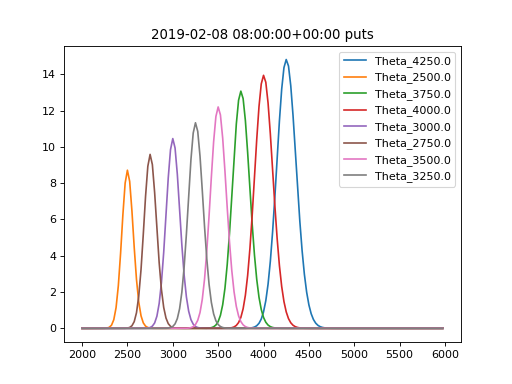

In [10]:
expiry = theo_engine.expirations[0]
plot_by_strike(option_df_dict, expiry, 'Theo')
plot_by_strike(option_df_dict, expiry, 'Delta')
plot_by_strike(option_df_dict, expiry, 'Gamma')
plot_by_strike(option_df_dict, expiry, 'Theta')